In [1]:
import numpy as np
import re
import os
import autokeras as ak
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, LayerNormalization
from ReadData import read_data_as_img, read_data_structured, read_data_st
from Preprocessing import ros, smote, adasyn
from Results import report_results_imagedata, make_spider_by_temp, report_results_st, test_results, plot_train_history
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from keras import Sequential
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, log_loss, fowlkes_mallows_score, cohen_kappa_score, precision_score, recall_score
from datetime import datetime
from contextlib import redirect_stdout
seed = 42
np.random.seed(seed)

In [27]:
data_dir = "../data"
X_train, y_train = read_data_st(data_dir, "train")
X_val, y_val = read_data_st(data_dir, "val")
X_test, y_test = read_data_st(data_dir, "test")

X_train = X_train.reshape(*X_train.shape[:3], 1)
X_val = X_val.reshape(*X_val.shape[:3], 1)
X_test = X_test.reshape(*X_test.shape[:3], 1)

In [ ]:
def widenet():
    model = keras.Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(11,200,1)))
    model.add(MaxPooling2D((1, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))

    model.add(Flatten())

    model.add(Dense(units=128, activation='relu'))

    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy", "AUC"])
    return model

In [54]:
model = widenet()

model.summary()

history = model.fit(X_train, y_train,
            shuffle=True,
            batch_size=32,
            epochs=20,
            verbose=True,
            validation_data=(X_val, y_val))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 9, 198, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 9, 99, 32)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 7, 97, 32)         9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 3, 48, 32)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 1, 46, 32)         9248      
_________________________________________________________________
flatten_14 (Flatten)         (None, 1472)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)             

KeyboardInterrupt: 

In [51]:
print("Train metrics:")
test_results(X_train, y_train, model)
print("Test metrics:")
test_results(X_test, y_test, model)

Train metrics:
	Accuracy score:  0.9178954362869263

	Binary crossentropy : 0.21403370797634125

	AUC ROC: 0.8734303712844849

Test metrics:
	Accuracy score:  0.9135144948959351

	Binary crossentropy : 0.2191430777311325

	AUC ROC: 0.873897910118103



In [52]:
from sklearn.metrics import confusion_matrix,roc_curve
y_test_pred = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
optimal_idx = np.argmax(tpr - fpr)
sensitivity = tpr[optimal_idx]
specificity = 1 - fpr[optimal_idx]
print("Threshold:", thresholds[optimal_idx])
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Threshold: 0.12746623
Sensitivity: 0.8134765625
Specificity: 0.798788825942567


In [ ]:
print("Train metrics:")
test_results(X_train, y_train, model)
print("Test metrics:")
test_results(X_test, y_test, model)

In [ ]:
from sklearn.metrics import confusion_matrix,roc_curve
y_test_pred = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
optimal_idx = np.argmax(tpr - fpr)
sensitivity = tpr[optimal_idx]
specificity = 1 - fpr[optimal_idx]
print("Threshold:", thresholds[optimal_idx])
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

## Visualize net structure

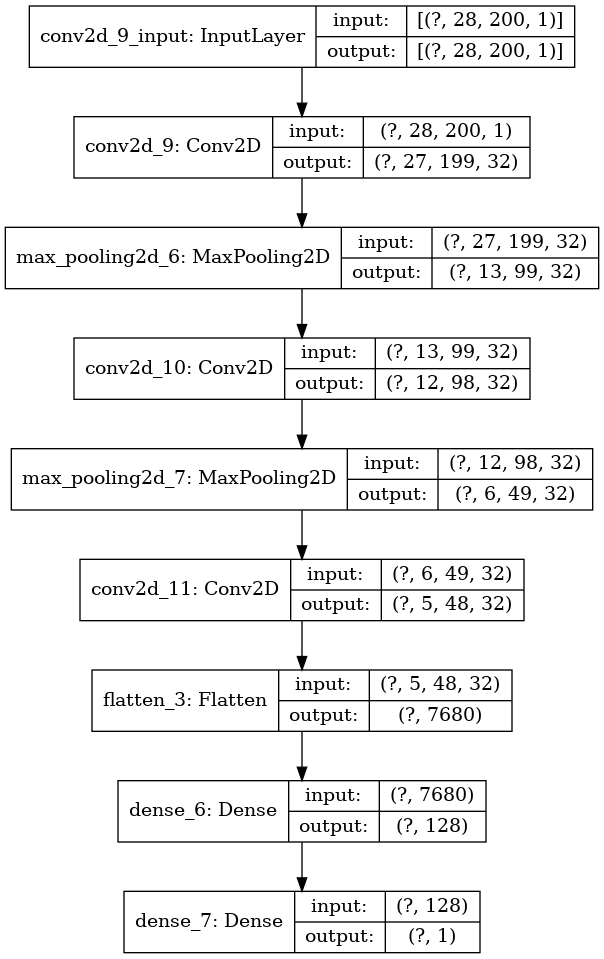

In [4]:
import pydot
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

model = keras.Sequential()

model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(28,200,1)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu'))

model.add(Flatten())

model.add(Dense(units=128))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy", "AUC"])

model = widenet()

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)